In [131]:
# import neccessary packages and libraries
import os
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Data Overview

The well known questions and answers website Stack Overflow has been conducted annual surveys for a decade now.  These are the largest and the most comprehensive surveys of coders ever conducted. The anonymized results of the surveys are publicly available for analysis at [Stack Overflow Anual Developer Survey](https://insights.stackoverflow.com/survey).

The 2020 Stack Overflow Survey was conducted in February 2020, just before the COVID-19 pandemic affected the entire world. The survey consists of 60 questions distributed over six sections:

1. Basic Information
2. Education, Work, Career
3. Technology and Tech Culture
4. Stack Overflow Usage + Community
5. Demographic Information
6. Survey Opinion and Final Questions

The survey had 64461 (almost 65k) responses from 184 countries and regions.

## Upload Data and Check the Uploads

There are two csv files, the `results_public` file contains the survey results and the `results_schema` file contains the list of columns in the first file, together with their associated questions. 

In [132]:
# create a path string
mypath = os.getcwd()

#upload datafiles as pandas dataframes

#df17 = pd.read_csv(path+'/data/survey17_results_public.csv', low_memory=False)
#df18 = pd.read_csv(path+'/data/survey18_results_public.csv', low_memory=False)
#df19 = pd.read_csv(path+'/data/survey19_results_public.csv', low_memory=False)
df = pd.read_csv(mypath+'/data/survey20_results_public.csv', low_memory=False)

#df17s = pd.read_csv(path+'/data/survey17_results_schema.csv', low_memory=False)
#df18s = pd.read_csv(path+'/data/survey18_results_schema.csv', low_memory=False)
#df19s = pd.read_csv(path+'/data/survey19_results_schema.csv', low_memory=False)
dfs = pd.read_csv(mypath+'/data/survey20_results_schema.csv', low_memory=False)

In [133]:
# the survey file
df.head(2)

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or software engineering",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or software engineering",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4


In [134]:
# display the full text of the string columns
pd.set_option('display.max_colwidth', None)

# the description file
dfs.head()

,Column,QuestionText
0,Respondent,Randomized respondent ID number (not in order of survey response time)
1,MainBranch,"Which of the following options best describes you today? Here, by ""developer"" we mean ""someone who writes code."""
2,Hobbyist,Do you code as a hobby?
3,Age,"What is your age (in years)? If you prefer not to answer, you may leave this question blank."
4,Age1stCode,"At what age did you write your first line of code or program? (e.g., webpage, Hello World, Scratch project)"


## General Data Information

In [135]:
# get the shape of the data
df.shape

(64461, 61)

In [136]:
# save the column names as a list
cols = list(dfs.Column.unique())
print(cols)

['Respondent', 'MainBranch', 'Hobbyist', 'Age', 'Age1stCode', 'CompFreq', 'CompTotal', 'ConvertedComp', 'Country', 'CurrencyDesc', 'CurrencySymbol', 'DatabaseDesireNextYear', 'DatabaseWorkedWith', 'DevType', 'EdLevel', 'Employment', 'Ethnicity', 'Gender', 'JobFactors', 'JobSat', 'JobSeek', 'LanguageDesireNextYear', 'LanguageWorkedWith', 'MiscTechDesireNextYear', 'MiscTechWorkedWith', 'NEWCollabToolsDesireNextYear', 'NEWCollabToolsWorkedWith', 'NEWDevOps', 'NEWDevOpsImpt', 'NEWEdImpt', 'NEWJobHunt', 'NEWJobHuntResearch', 'NEWLearn', 'NEWOffTopic', 'NEWOnboardGood', 'NEWOtherComms', 'NEWOvertime', 'NEWPurchaseResearch', 'NEWPurpleLink', 'NEWSOSites', 'NEWStuck', 'OpSys', 'OrgSize', 'PlatformDesireNextYear', 'PlatformWorkedWith', 'PurchaseWhat', 'Sexuality', 'SOAccount', 'SOComm', 'SOPartFreq', 'SOVisitFreq', 'SurveyEase', 'SurveyLength', 'Trans', 'UndergradMajor', 'WebframeDesireNextYear', 'WebframeWorkedWith', 'WelcomeChange', 'WorkWeekHrs', 'YearsCode', 'YearsCodePro']


In [137]:
# general data information including the non-null values
#df.info();

In [138]:
# get the number of NaN values in each column
df_null = df.isnull().sum()
df_null

Respondent                0
MainBranch              299
Hobbyist                 45
Age                   19015
Age1stCode             6561
                      ...  
WebframeWorkedWith    22182
WelcomeChange         11778
WorkWeekHrs           23310
YearsCode              6777
YearsCodePro          18112
Length: 61, dtype: int64

In [139]:
# the columns with no missing data
no_null = set(df.columns[np.sum(df.isnull()) == 0]) 
no_null

{'Respondent'}

In [140]:
# there are no columns with more than 50% values missing
most_missing_cols = df.columns[df.isnull().mean() > 0.50]
most_missing_cols

Index([], dtype='object')

In [141]:
# most missing values, in descending order, written as percentages
df.isnull().mean().sort_values(ascending=False).round(3)

ConvertedComp             0.461
CompTotal                 0.460
NEWPurchaseResearch       0.421
PurchaseWhat              0.389
WebframeDesireNextYear    0.379
                          ...  
Employment                0.009
Country                   0.006
MainBranch                0.005
Hobbyist                  0.001
Respondent                0.000
Length: 61, dtype: float64

In [142]:
# columns with more than 30% values missing
most_missing_vals = df.columns[df.isnull().mean() > 0.30]
most_missing_vals

Index(['CompFreq', 'CompTotal', 'ConvertedComp', 'DatabaseDesireNextYear',
       'MiscTechDesireNextYear', 'MiscTechWorkedWith', 'NEWDevOps',
       'NEWDevOpsImpt', 'NEWJobHunt', 'NEWJobHuntResearch', 'NEWOnboardGood',
       'NEWOvertime', 'NEWPurchaseResearch', 'OrgSize', 'PurchaseWhat',
       'Sexuality', 'WebframeDesireNextYear', 'WebframeWorkedWith',
       'WorkWeekHrs'],
      dtype='object')

In [143]:
# look at the numerical data
df.describe()

,Respondent,Age,CompTotal,ConvertedComp,WorkWeekHrs
count,64461.000000,45446.000000,3.482600e+04,3.475600e+04,41151.000000
mean,32554.079738,30.834111,3.190464e+242,1.037561e+05,40.782174
std,18967.442360,9.585392,inf,2.268853e+05,17.816383
min,1.000000,1.000000,0.000000e+00,0.000000e+00,1.000000
25%,16116.000000,24.000000,2.000000e+04,2.464800e+04,40.000000
50%,32231.000000,29.000000,6.300000e+04,5.404900e+04,40.000000
75%,49142.000000,35.000000,1.250000e+05,9.500000e+04,44.000000
max,65639.000000,279.000000,1.111111e+247,2.000000e+06,475.000000


## Specific Information from Data

### Distribution by country

In [144]:
# the number of countries involved
len(df.Country.unique())

184

In [145]:
# distribution of respondends on countries
country_counts = df.Country.value_counts()
country_counts.head(8)

United States     12469
India              8403
United Kingdom     3896
Germany            3890
Canada             2191
France             1898
Brazil             1818
Netherlands        1343
Name: Country, dtype: int64

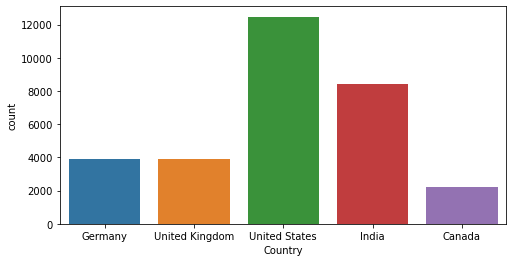

In [146]:
# the most represented countries, more than 2000 respondents
df_most_repres_countries = df[df.Country.map(df.Country.value_counts()) > 2000]

# set the figure size
plt.figure(figsize = [8,4])

# bar chart of more represented countries
sns.countplot(data=df_most_repres_countries, x='Country');

In [147]:
# percentage of most represented countries respondents
df_most_repres_countries.shape[0]/df.shape[0]

0.4785684367291851

In [148]:
# countries with less than 100 respondents
least_represented_countries = country_counts[country_counts < 100]
len(least_represented_countries)

114

### Distribution by gender

In [149]:
# distribution by gender in counts
df.Gender.value_counts()

Man                                                            46013
Woman                                                           3844
Non-binary, genderqueer, or gender non-conforming                385
Man;Non-binary, genderqueer, or gender non-conforming            121
Woman;Non-binary, genderqueer, or gender non-conforming           92
Woman;Man                                                         76
Woman;Man;Non-binary, genderqueer, or gender non-conforming       26
Name: Gender, dtype: int64

In [150]:
# distribution by gender in percentages
df.Gender.value_counts()/df.shape[0]

Man                                                            0.713811
Woman                                                          0.059633
Non-binary, genderqueer, or gender non-conforming              0.005973
Man;Non-binary, genderqueer, or gender non-conforming          0.001877
Woman;Non-binary, genderqueer, or gender non-conforming        0.001427
Woman;Man                                                      0.001179
Woman;Man;Non-binary, genderqueer, or gender non-conforming    0.000403
Name: Gender, dtype: float64

In [151]:
# what percentage of Gender entries are missing
df.Gender.isnull().sum()/df.shape[0]

0.21569631249903043

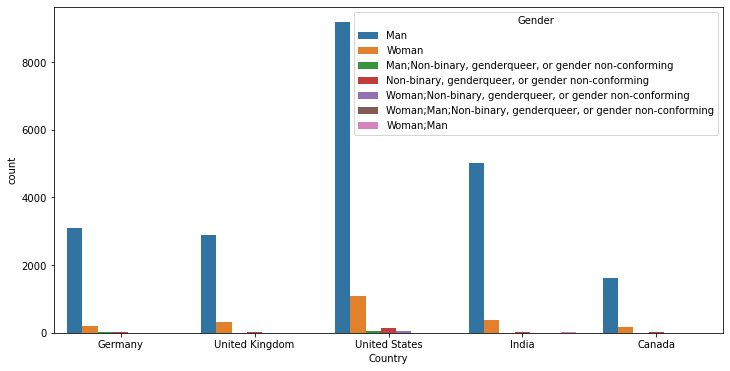

In [152]:
# distribution by gender and country with most respondents
df_most_repres_countries = df[df.Country.map(df.Country.value_counts()) > 2000]

# set the figure size
plt.figure(figsize = [12,6])

# adapted clustered bar chart of country and gender
sns.countplot(data=df_most_repres_countries, x='Country', hue='Gender');

### Look over questions and identify columns to drop

In [153]:
pd.set_option('display.max_colwidth', None)
# take a look at the questions - first part
dfs.head(2)

,Column,QuestionText
0,Respondent,Randomized respondent ID number (not in order of survey response time)
1,MainBranch,"Which of the following options best describes you today? Here, by ""developer"" we mean ""someone who writes code."""


In [154]:
# take a look at the questions, part 2
dfs.tail(2)

,Column,QuestionText
59,YearsCode,"Including any education, how many years have you been coding in total?"
60,YearsCodePro,"NOT including education, how many years have you coded professionally (as a part of your work)?"


In [155]:
# some of the columns are not relevant for our analysis
drop_cols = ['CompFreq', 'CompTotal', 'CurrencyDesc', 'CurrencySymbol', 'Ethnicity', 
             'NEWOffTopic', 'Sexuality', 'SurveyEase', 'SurveyLength', 'Trans']

# make a copy of the dataframe
df1 = df.copy()

# drop all the columns in the list drop_cols
df1 = df1.drop(drop_cols, axis = 1)

# check the shape of the new dataset
df1.shape

(64461, 51)

### What type of developer are you?

In [156]:
# print the question of interest
list(dfs[dfs.Column == 'MainBranch']['QuestionText'])

['Which of the following options best describes you today? Here, by "developer" we mean "someone who writes code."']

In [157]:
# profesional status as a developer
df1.MainBranch.value_counts().reset_index()

,index,MainBranch
0,I am a developer by profession,47193
1,I am a student who is learning to code,7970
2,"I am not primarily a developer, but I write code sometimes as part of my work",5502
3,I code primarily as a hobby,2314
4,"I used to be a developer by profession, but no longer am",1183


In [158]:
# print the question of interest
list(dfs[dfs.Column == 'DevType']['QuestionText'])

['Which of the following describe you? Please select all that apply.']

In [160]:
# respondents choose more than one answer as we can see below
developers = df1.DevType.value_counts().reset_index()
developers.head(4)

,index,DevType
0,"Developer, full-stack",4424
1,"Developer, back-end",3086
2,"Developer, back-end;Developer, front-end;Developer, full-stack",2227
3,"Developer, back-end;Developer, full-stack",1476


In [161]:
# rename the columns in the results dataframe
developers.rename(columns = {'index':'devChoice', 'DevType':'count'}, inplace=True)
developers.head(12)

,devChoice,count
0,"Developer, full-stack",4424
1,"Developer, back-end",3086
2,"Developer, back-end;Developer, front-end;Developer, full-stack",2227
3,"Developer, back-end;Developer, full-stack",1476
4,"Developer, front-end",1401
5,"Developer, mobile",1251
6,"Developer, front-end;Developer, full-stack",830
7,"Developer, back-end;Developer, desktop or enterprise applications;Developer, front-end;Developer, full-stack",813
8,"Developer, back-end;Developer, desktop or enterprise applications",650
9,"Developer, desktop or enterprise applications",606


In [162]:
# remove all caps from devChoice column
developers.devChoice = developers.devChoice.str.lower()
developers.head(3)

,devChoice,count
0,"developer, full-stack",4424
1,"developer, back-end",3086
2,"developer, back-end;developer, front-end;developer, full-stack",2227


In [163]:
# create a list of the individual answers that can be marked by a user
dev_choice = list(developers.devChoice.str.split(';', expand=True)[0].unique())
print(dev_choice)

['developer, full-stack', 'developer, back-end', 'developer, front-end', 'developer, mobile', 'developer, desktop or enterprise applications', 'developer, embedded applications or devices', 'data scientist or machine learning specialist', 'data or business analyst', 'developer, qa or test', 'designer', 'academic researcher', 'engineering manager', 'engineer, data', 'devops specialist', 'system administrator', 'database administrator', 'developer, game or graphics', 'senior executive/vp', 'scientist', 'product manager', 'educator', 'engineer, site reliability', 'marketing or sales professional']


In [48]:
# the list of data science related developers
data_dev = [dev_choice[6], dev_choice[7], dev_choice[12]]
print(data_dev)

['data scientist or machine learning specialist', 'data or business analyst', 'engineer, data']


In [68]:
#replace NaN with the string none in DevType column
df1.DevType = df1.DevType.fillna('non')

# lowercase all strings
df1.DevType = df1.DevType.str.lower()

In [129]:
# create a function that will count type of strings 
def counts_strings(strings_list, dataframe, col1):
    my_counts = defaultdict(int)
    for entry in strings_list:
        my_counts[entry] = dataframe[col1].str.count(entry).sum()
    new_df = pd.DataFrame.from_dict(my_counts, orient = 'index').reset_index()
    new_df.columns=[col1]
    return new_df
    

In [130]:
counts_strings(dev_choice, df1, 'DevType')

ValueError: Length mismatch: Expected axis has 2 elements, new values have 1 elements

In [36]:
# use defaultdict to work with columns with missing values
new_res = defaultdict(int)

# function to count all unique strings
def count_strings(pos_vals, dframe, col1, col2):
    for entry in pos_vals:
        for idx in range(dframe.shape[0]):
            if entry in dframe[col1][idx]:
                new_res[entry] += dframe[col2][idx]
    # create a dataframe from the dictionary
    new_df = pd.DataFrame.from_dict(new_res, orient = 'index').reset_index()
    # rename columns
    new_df.columns = [col1, col2]
    return new_df

In [70]:
# create empty dictionary, which will hold info [method]: count
my_counts = {}
# iterate through possible answers
for entry in dev_choice:
    my_counts[entry] = df1.DevType.str.count(entry).sum()
# check the counts dictionary
my_counts

{'developer, full-stack': 27125,
 'developer, back-end': 27228,
 'developer, front-end': 18296,
 'developer, mobile': 9482,
 'developer, desktop or enterprise applications': 11784,
 'developer, embedded applications or devices': 4750,
 'data scientist or machine learning specialist': 3988,
 'data or business analyst': 4024,
 'developer, qa or test': 3947,
 'designer': 5321,
 'academic researcher': 3552,
 'engineering manager': 2724,
 'engineer, data': 3738,
 'devops specialist': 5969,
 'system administrator': 5242,
 'database administrator': 5722,
 'developer, game or graphics': 2789,
 'senior executive/vp': 1320,
 'scientist': 6074,
 'product manager': 2497,
 'educator': 2928,
 'engineer, site reliability': 1940,
 'marketing or sales professional': 642,
 'non': 15091}

In [72]:
# create empty dictionary, which will hold info [method]: count
my_count = {}
# iterate through possible answers
for entry in dev_choice:
    my_count[entry] = df1.DevType.str.contains(entry).sum()
# check the counts dictionary
my_count

{'developer, full-stack': 27125,
 'developer, back-end': 27228,
 'developer, front-end': 18296,
 'developer, mobile': 9482,
 'developer, desktop or enterprise applications': 11784,
 'developer, embedded applications or devices': 4750,
 'data scientist or machine learning specialist': 3988,
 'data or business analyst': 4024,
 'developer, qa or test': 3947,
 'designer': 5321,
 'academic researcher': 3552,
 'engineering manager': 2724,
 'engineer, data': 3738,
 'devops specialist': 5969,
 'system administrator': 5242,
 'database administrator': 5722,
 'developer, game or graphics': 2789,
 'senior executive/vp': 1320,
 'scientist': 5179,
 'product manager': 2497,
 'educator': 2928,
 'engineer, site reliability': 1940,
 'marketing or sales professional': 642,
 'non': 15091}

In [74]:
df1_data = df1[df1.DevType.str.contains('data ')]
df1_data.shape

(6715, 51)

In [119]:
# respondents choose more than one answer as we can see below
developers_data = df1_data.DevType.value_counts().reset_index()
developers_data.head(12)

,index,DevType
0,data scientist or machine learning specialist,369
1,data or business analyst,285
2,data or business analyst;data scientist or machine learning specialist,186
3,"data scientist or machine learning specialist;developer, back-end",129
4,academic researcher;data scientist or machine learning specialist;scientist,96
5,academic researcher;data scientist or machine learning specialist,90
6,"data scientist or machine learning specialist;developer, full-stack",84
7,"data scientist or machine learning specialist;engineer, data",73
8,"data or business analyst;developer, back-end",72
9,"data or business analyst;data scientist or machine learning specialist;engineer, data",69


In [76]:
# create empty dictionary, which will hold info [method]: count
my_count_datas = {}
# iterate through possible answers
for entry in dev_choice:
    my_count_datas[entry] = df1_data.DevType.str.count(entry).sum()
# check the counts dictionary
my_count_datas

{'developer, full-stack': 2838,
 'developer, back-end': 3470,
 'developer, front-end': 1925,
 'developer, mobile': 1027,
 'developer, desktop or enterprise applications': 1683,
 'developer, embedded applications or devices': 770,
 'data scientist or machine learning specialist': 3988,
 'data or business analyst': 4024,
 'developer, qa or test': 727,
 'designer': 1059,
 'academic researcher': 1409,
 'engineering manager': 539,
 'engineer, data': 1727,
 'devops specialist': 970,
 'system administrator': 1149,
 'database administrator': 1793,
 'developer, game or graphics': 441,
 'senior executive/vp': 377,
 'scientist': 4999,
 'product manager': 717,
 'educator': 726,
 'engineer, site reliability': 362,
 'marketing or sales professional': 255,
 'non': 0}

In [107]:
# make dataframe from dictionary
data_pd = pd.DataFrame(pd.Series(my_count_datas)).reset_index()

# rename the columns in the results dataframe
data_pd.rename(columns = {'index':'devChoice', 0:'counts'}, inplace=True)
data_pd_sort = data_pd.sort_values('counts', ascending=False)
data_pd_sort.head(10)

,devChoice,counts
18,scientist,4999
7,data or business analyst,4024
6,data scientist or machine learning specialist,3988
1,"developer, back-end",3470
0,"developer, full-stack",2838
2,"developer, front-end",1925
15,database administrator,1793
12,"engineer, data",1727
4,"developer, desktop or enterprise applications",1683
10,academic researcher,1409


In [108]:
data_pd_sort.drop([7, 6, 12, 23], inplace=True)

In [109]:
data_pd_sort

,devChoice,counts
18,scientist,4999
1,"developer, back-end",3470
0,"developer, full-stack",2838
2,"developer, front-end",1925
15,database administrator,1793
4,"developer, desktop or enterprise applications",1683
10,academic researcher,1409
14,system administrator,1149
9,designer,1059
3,"developer, mobile",1027


In [121]:
# set the figure size
plt.figure(figsize = [12,6])
df1_data["dataPeople"] = df1_data["DevType"].isin(["data "])

# adapted clustered bar chart of country and gender
sns.barplot(data=df1_data, x = 'counts', y ='devChoice', hue='dataPeople');

ValueError: min() arg is an empty sequence

<Figure size 864x432 with 0 Axes>

In [40]:

df["Name"]= df["Name"].str.lower()
# count occurrences of each developer choice
dev_counts = count_strings(dev_choices, developers, 'devChoice', 'count')
# look at these results as percentages
dev_counts['perc'] = dev_counts['count']/np.sum(dev_counts['count'])
# sort the values in decreasing order of counts/percentage
dev_counts.sort_values(by='count', ascending=False).round(3)

,devChoice,count,perc
1,"Developer, back-end",54456,0.167
0,"Developer, full-stack",54250,0.166
2,"Developer, front-end",36592,0.112
4,"Developer, desktop or enterprise applications",23568,0.072
3,"Developer, mobile",18964,0.058
7,Data or business analyst,12072,0.037
6,Data scientist or machine learning specialist,11964,0.037
13,DevOps specialist,11938,0.037
15,Database administrator,11444,0.035
12,"Engineer, data",11214,0.034


In [ ]:
#replace NaN with the string none in DevType column
df_copy[['DevType']] = df_copy[['DevType']].fillna('none')

# dataframe that contains the data developers
df_data = df_copy[df_copy.DevType.str.contains('Data |, data')]
df_data.head(6)

In [ ]:
df_data.shape

### Question

For those who identify as working with data, what other type of developers they choose?

In [ ]:
df_copy[['DevType']] = df_copy[['DevType']].fillna('none') # Specific columns
df_copy.head()

In [ ]:
# drop those rows that have null values in DevType column
df1 = df.dropna(subset=['DevType'], axis=0)
df1.shape

In [ ]:
# find all entries that contain data option 
# use pd.series.str.contains(pat, case=True, flags=0, na=nan, regex=True)
contain_datas = df1[df1['DevType'].str.contains('Data', case=False)]
contain_datas.shape

In [ ]:
# check the dataframe
contain_datas.head(4)

In [ ]:
df_temp = df['DevType'].dropna(axis=0).reset_index(drop=True)


In [ ]:
df_temp[df_temp['DevType'].str.contains("Data scientist or machine learning specialist")]

In [ ]:
df20.info().isnull().sum()

In [ ]:
df20['DevType'].isnull().sum()

In [ ]:
desc = list(df20s[df20s.Column == 'DevType']['QuestionText'])[0]
desc

In [ ]:
print(list(df20['DevType'].unique()))

In [ ]:
datas = df20['DevType'].value_counts()
datas

In [ ]:
# create a list of the individual answers that are marked by a user
# this is also available in the documentation
pd_series = df20['DevType']
pos_values = pd_series.str.split(';', expand=True)[0].unique()
pos_values